<a href="https://colab.research.google.com/github/eleanarey/ProgramingPractices/blob/main/Implementacion_de_Mobile_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]


if use_gdrive == 'yes':
  from google.colab import drive
  # Montar Google Drive
  # "comentamos esta celda y añadimos la siguiente" drive.mount('/gdrive')
  drive.mount('/content/drive', force_remount=True)
  # Ruta al archivo ZIP en Google Drive
  # "comentamos esta celda y añadimos la siguiente" root = '/gdrive/My Drive/vision_transformer_colab'
  root = "/content/drive/MyDrive/Colab_Notebooks"
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Mounted at /content/drive

Changed CWD to "/content/drive/MyDrive/Colab_Notebooks"


In [10]:
# Clonar el repositorio
#!git clone https://github.com/quic/ai-hub-models.git
%cd ai-hub-models/qai_hub_models/models/mobile_vit
!pip install -r requirements.txt
!pip install "qai_hub_models[mobile-vit]"
!pip install transformers torch torchvision


[Errno 2] No such file or directory: 'ai-hub-models/qai_hub_models/models/mobile_vit'
/content
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/ai-hub-models')
!ls

'=0.0.3'				     ilsvrc2012_wordnet_lemmas.txt.1
'=0.1.0'				     implementacion_de_vit_jax.ipynb
'=0.2.0'				     implementacion_de_vit_jax_local.ipynb
'=0.3.0'				     jupyter_local
'=2.9.0'				     Let-me-see
 ai-hub-models				     picsum.jpg
 annotations_trainval2017.zip		     tfm_eleana_v2.ipynb
 borrar_25_dic				     TFM_Multimodal_Clasification.ipynb
 build					     tfm_v3.ipynb
 cifar10_images.npz			     Untitled0.ipynb
'Copia de implementacion_de_vit_jax.ipynb'   vision_transformer
'Copia de tfm_v3.ipynb'			     ViT-B_32_imagenet2012.npz
'curso anterior  IA'			     ViT-B_32.npz
 dataset				     yolov5s.pt
 ilsvrc2012_wordnet_lemmas.txt


In [4]:
#1. Carga de datos
#   En conjunto de datos esta dividido en dos carpetas: text (con texto) y no_text (sin texto).
#   Usa torchvision.datasets.ImageFolder para cargar estos datos y dividirlos en conjuntos de entrenamiento y validación.

import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Definir transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Cambia según lo que requiere MobileViT
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalización estándar
])

# Cargar el dataset con ImageFolder
dataset_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/text_recognition"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Dividir en entrenamiento y validación
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
val_size = len(dataset) - train_size  # 20% para validación
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Crear dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [7]:
#2. Configura el modelo MobileViT
#   Carga MobileViT preentrenado y ajusta la última capa para clasificar imágenes en 2 clases (text y no_text).

#from model import MobileVIT
from qai_hub_models.models.mobile_vit.model import MobileVIT

# Cargar el modelo preentrenado
model = MobileVIT.from_pretrained()

# Configura la última capa para tu caso específico (2 clases: text y no_text)
import torch.nn as nn
model.net.classifier = nn.Linear(model.net.classifier.in_features, 2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/mobilevit/feature_extraction_mobilevit.py:28: FutureWarning: The class MobileViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

In [11]:
# 3. Definir el optimizador y la función de pérdida
#    Configura el optimizador y la función de pérdida para el entrenamiento.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # Pérdida de clasificación
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizador Adam


In [13]:
# 4. Entrenar el modelo
#    Define un bucle de entrenamiento para actualizar los pesos del modelo usando los datos de entrenamiento.

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Limpiar gradientes
        outputs = model(inputs)  # Forward
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward
        optimizer.step()  # Actualizar pesos

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/5, Loss: 0.0913
Epoch 2/5, Loss: 0.0148
Epoch 3/5, Loss: 0.0039
Epoch 4/5, Loss: 0.0010
Epoch 5/5, Loss: 0.0002


Accuracy en validación: 100.00%


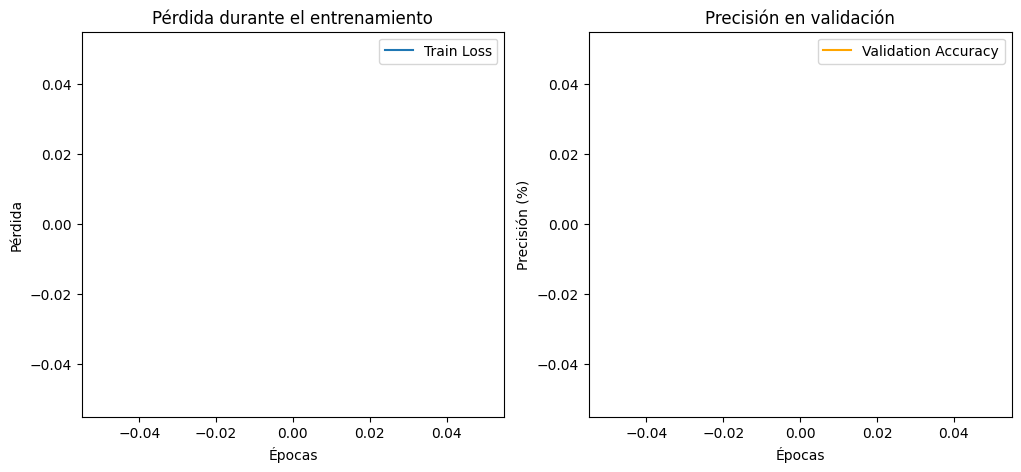

In [15]:
# 5. Evaluar el modelo
#    Después del entrenamiento, evalúa el modelo en el conjunto de validación y calcula la precisión.

import matplotlib.pyplot as plt
import torch.optim as optim

# Inicializar listas para almacenar métricas
train_losses = []
val_accuracies = []

from sklearn.metrics import accuracy_score

model.eval()  # Poner el modelo en modo evaluación
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)  # Forward
        _, predictions = torch.max(outputs, 1)  # Predicciones
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Calcular precisión
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy en validación: {accuracy * 100:.2f}%")


# Graficar resultados
plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdida durante el entrenamiento")
plt.legend()

# Precisión de validación
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy", color="orange")
plt.xlabel("Épocas")
plt.ylabel("Precisión (%)")
plt.title("Precisión en validación")
plt.legend()

plt.show()


In [20]:
# 6. Guardar el modelo entrenado
#    Guarda el modelo fine-tuneado para su uso posterior.

torch.save(model.state_dict(), "mobilevit_text_classification_v1.pth")

import os
print(f"Modelo salvado en la ruta: {os.getcwd()}")
!ls

Modelo salvado en la ruta: /content/drive/MyDrive/Colab_Notebooks
'=0.0.3'				     implementacion_de_vit_jax.ipynb
'=0.1.0'				     implementacion_de_vit_jax_local.ipynb
'=0.2.0'				     jupyter_local
'=0.3.0'				     Let-me-see
'=2.9.0'				     mobilevit_text_classification.pth
 ai-hub-models				     mobilevit_text_classification_v1.pth
 annotations_trainval2017.zip		     picsum.jpg
 borrar_25_dic				     tfm_eleana_v2.ipynb
 build					     TFM_Multimodal_Clasification.ipynb
 cifar10_images.npz			     tfm_v3.ipynb
'Copia de implementacion_de_vit_jax.ipynb'   Untitled0.ipynb
'Copia de tfm_v3.ipynb'			     vision_transformer
'curso anterior  IA'			     ViT-B_32_imagenet2012.npz
 dataset				     ViT-B_32.npz
 ilsvrc2012_wordnet_lemmas.txt		     yolov5s.pt
 ilsvrc2012_wordnet_lemmas.txt.1


Predicción: text


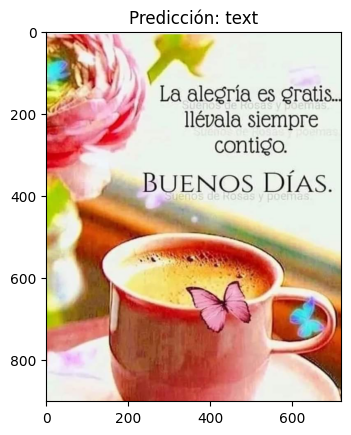

In [17]:
# 7. Mostrar resultados adicionales,
#    como ejemplos de predicciones del modelo sobre nuevas imágenes.

from PIL import Image
import matplotlib.pyplot as plt

# Cargar una imagen de prueba
img_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppMensajesMotivacion/IMG-20231119-WA0000.jpg"
img = Image.open(img_path)
img_transformed = transform(img).unsqueeze(0).to(device)  # Preprocesar

# Realizar una predicción
model.eval()
with torch.no_grad():
    output = model(img_transformed)
    _, pred = torch.max(output, 1)

# Mostrar resultado
classes = ['no_text', 'text']
print(f"Predicción: {classes[pred.item()]}")
plt.imshow(img)
plt.title(f"Predicción: {classes[pred.item()]}")
plt.show()


In [8]:
import torch
from PIL import Image
from torchvision import transforms

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar una imagen de prueba
img = Image.open('/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppMensajesMotivacion/IMG-20231207-WA0000.jpg')
img_tensor = transform(img).unsqueeze(0)  # Añadir dimensión batch

# Realizar una predicción
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)
    print("Predicciones:", outputs)


Predicciones: tensor([[ 0.8989, -0.5958]])


In [9]:
!python -m qai_hub_models.models.mobile_vit_v2.export

2025-01-10 12:10:41.401301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-10 12:10:41.480525: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-10 12:10:41.490623: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 12:10:43.653374: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Unable to find a valid API token for Qualcomm® AI Hub. Using results from a previous job run on the same device.
To get access to the complete experience, please sign-up for access at https://aihub.qualcomm.com.

Profiling Results
----------

Epoch 1/5, Loss: 0.0159
Validation Accuracy: 100.00%
Epoch 2/5, Loss: 0.0005
Validation Accuracy: 100.00%
Epoch 3/5, Loss: 0.0001
Validation Accuracy: 100.00%
Epoch 4/5, Loss: 0.0115
Validation Accuracy: 99.88%
Epoch 5/5, Loss: 0.0181
Validation Accuracy: 100.00%


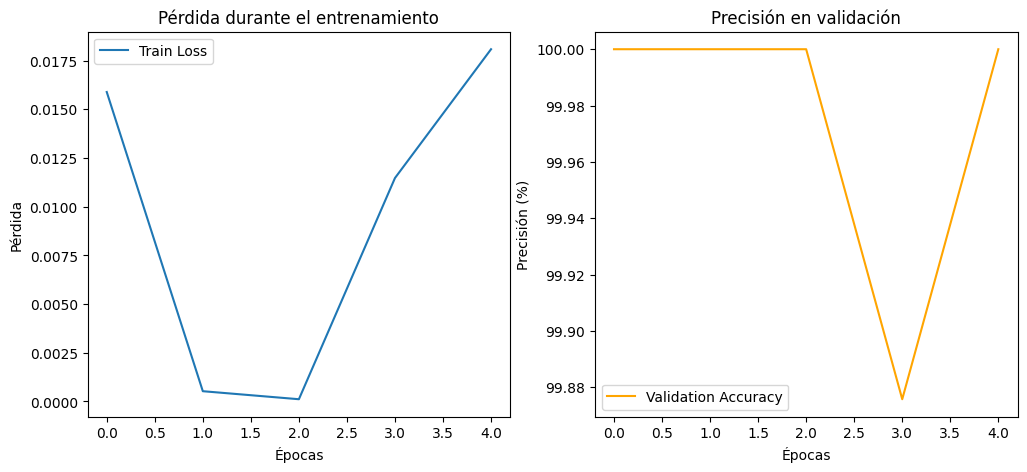

In [18]:
# Re entrenamos 5 epocas mas y mostramos resultados
# Qué hace este código:
# Registra las métricas:
# Almacena la pérdida de entrenamiento (train_losses).
# Calcula la precisión en validación (val_accuracies) después de cada época.

# Genera gráficos:
# Gráfico de la pérdida durante el entrenamiento.
# Gráfico de la precisión en el conjunto de validación.

# Visualización en Colab:
# Muestra los gráficos usando Matplotlib directamente en el cuaderno.

import matplotlib.pyplot as plt
import torch.optim as optim

# Configuración de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Inicializar listas para almacenar métricas
train_losses = []
val_accuracies = []

num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Bucle de entrenamiento con registro de métricas
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    # Evaluar el modelo en validación después de cada época
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    print(f"Validation Accuracy: {accuracy:.2f}%")

# Graficar resultados
plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdida durante el entrenamiento")
plt.legend()

# Precisión de validación
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy", color="orange")
plt.xlabel("Épocas")
plt.ylabel("Precisión (%)")
plt.title("Precisión en validación")
plt.legend()

plt.show()


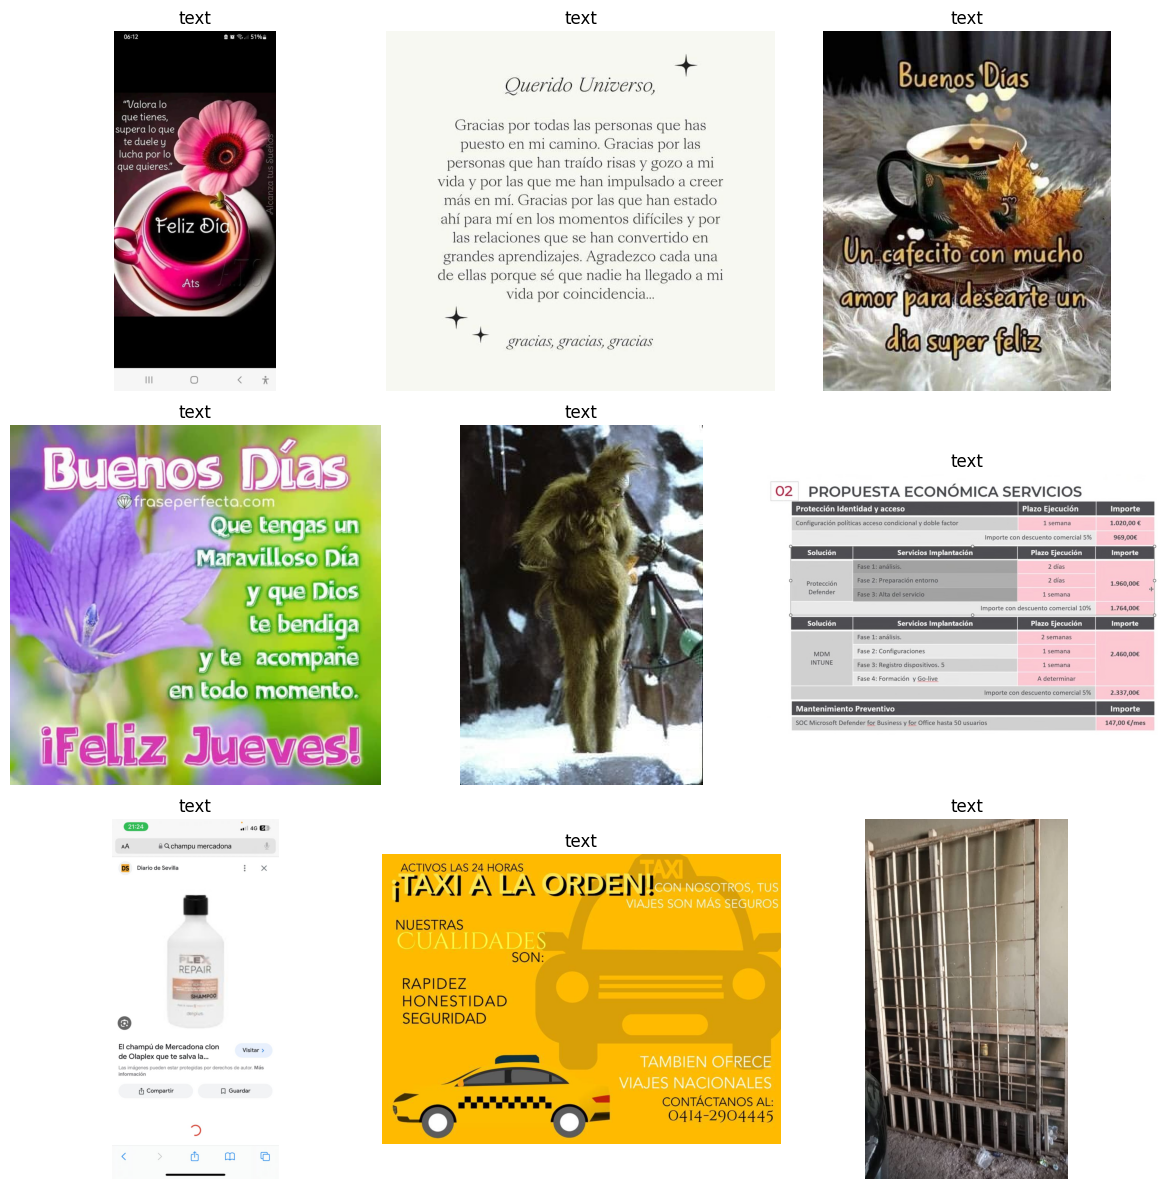

In [21]:
# Código para evaluar todas las imágenes de un directorio y
# mostrar un grid de imágenes con sus clasificaciones

import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Transformaciones para preprocesar imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Ajustar según tu modelo
])

# Clases del modelo
classes = ['no_text', 'text']

# Función para evaluar imágenes en un directorio
def evaluate_images_in_directory(model, directory_path, device, max_images=9):
    """
    Evalúa todas las imágenes en un directorio y muestra un grid con las predicciones del modelo.

    Args:
        model: Modelo entrenado para evaluación.
        directory_path: Ruta al directorio con imágenes.
        device: Dispositivo (CPU/GPU) en el que correr el modelo.
        max_images: Número máximo de imágenes a mostrar en el grid (default: 9).
    """
    # Obtener la lista de imágenes en el directorio
    image_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    if not image_paths:
        print("No se encontraron imágenes en el directorio.")
        return

    # Limitar al número máximo de imágenes
    image_paths = image_paths[:max_images]

    model.eval()  # Poner el modelo en modo evaluación
    images = []
    predictions = []

    with torch.no_grad():
        for img_path in image_paths:
            # Cargar y preprocesar cada imagen
            img = Image.open(img_path).convert('RGB')
            img_transformed = transform(img).unsqueeze(0).to(device)

            # Predicción del modelo
            output = model(img_transformed)
            _, pred = torch.max(output, 1)

            # Guardar imagen y predicción
            images.append(img)
            predictions.append(classes[pred.item()])

    # Mostrar las imágenes en un grid
    show_image_grid(images, predictions)

# Función para mostrar un grid de imágenes con títulos
def show_image_grid(images, titles, rows=3, cols=3):
    """
    Muestra un grid de imágenes con títulos.

    Args:
        images: Lista de imágenes (PIL Images).
        titles: Lista de títulos para cada imagen.
        rows: Número de filas en el grid.
        cols: Número de columnas en el grid.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()

    for img, title, ax in zip(images, titles, axes):
        ax.imshow(img)
        ax.set_title(title, fontsize=12)
        ax.axis('off')

    # Ocultar los ejes adicionales si hay menos imágenes que slots
    for ax in axes[len(images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Ruta al directorio con imágenes
directory_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppImagesPruebaTexto"

# Evaluar y mostrar resultados
evaluate_images_in_directory(model, directory_path, device, max_images=9)


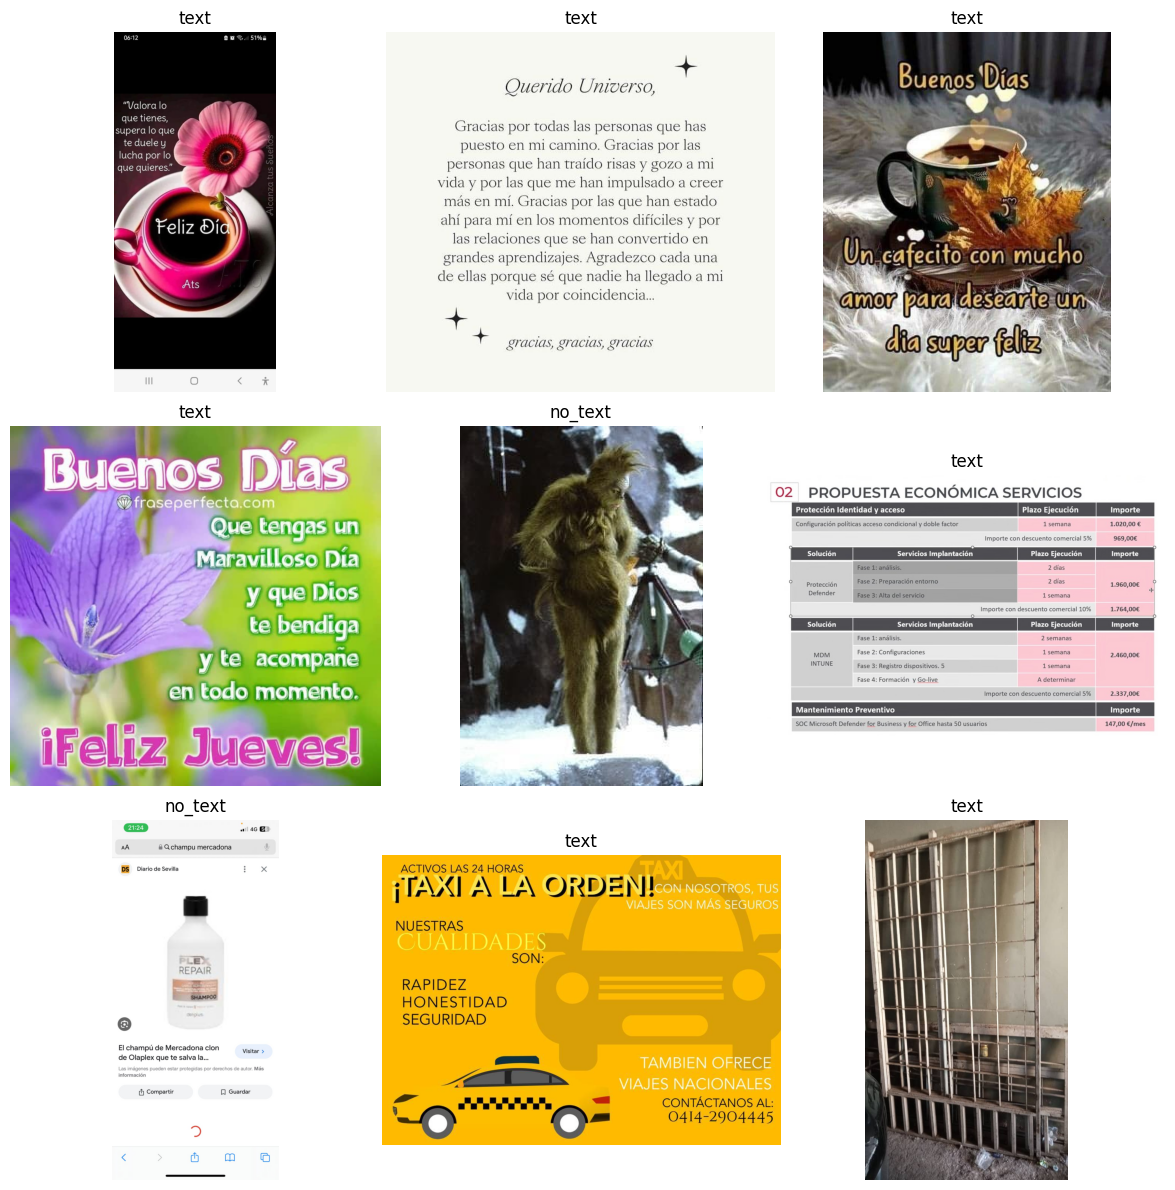

In [23]:
# Código para evaluar todas las imágenes de un directorio y
# mostrar un grid de imágenes con sus clasificaciones usando el
# modelo CLIP de la biblioteca transformers

from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os

# Inicializar el modelo y el procesador CLIP
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Clases objetivo (puedes ajustar según tu caso)
classes = ["text", "no_text"]

# Función para evaluar imágenes en un directorio usando CLIP
def evaluate_images_with_clip(model, processor, directory_path, device, max_images=9):
    """
    Evalúa todas las imágenes en un directorio y muestra un grid con las predicciones de CLIP.

    Args:
        model: Modelo CLIP preentrenado.
        processor: Procesador asociado al modelo CLIP.
        directory_path: Ruta al directorio con imágenes.
        device: Dispositivo (CPU/GPU) en el que correr el modelo.
        max_images: Número máximo de imágenes a mostrar en el grid (default: 9).
    """
    # Obtener la lista de imágenes en el directorio
    image_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    if not image_paths:
        print("No se encontraron imágenes en el directorio.")
        return

    # Limitar al número máximo de imágenes
    image_paths = image_paths[:max_images]

    images = []
    predictions = []

    model.eval()  # Modo evaluación
    with torch.no_grad():
        for img_path in image_paths:
            # Cargar la imagen y procesarla
            img = Image.open(img_path).convert("RGB")
            inputs = processor(images=img, return_tensors="pt", padding=True).to(device)

            # Obtener características de texto
            text_inputs = processor(text=classes, return_tensors="pt", padding=True).to(device)

            # Realizar la inferencia con CLIP
            image_features = model.get_image_features(**inputs)
            text_features = model.get_text_features(**text_inputs)

            # Calcular similitud entre imagen y texto
            logits_per_image = image_features @ text_features.T
            probs = logits_per_image.softmax(dim=1)  # Convertir a probabilidades

            # Guardar la imagen y la predicción
            pred_class = classes[torch.argmax(probs).item()]
            images.append(img)
            predictions.append(pred_class)

    # Mostrar las imágenes en un grid
    show_image_grid(images, predictions)


# Función para mostrar un grid de imágenes con títulos
def show_image_grid(images, titles, rows=3, cols=3):
    """
    Muestra un grid de imágenes con títulos.

    Args:
        images: Lista de imágenes (PIL Images).
        titles: Lista de títulos para cada imagen.
        rows: Número de filas en el grid.
        cols: Número de columnas en el grid.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()

    for img, title, ax in zip(images, titles, axes):
        ax.imshow(img)
        ax.set_title(title, fontsize=12)
        ax.axis('off')

    # Ocultar los ejes adicionales si hay menos imágenes que slots
    for ax in axes[len(images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Ruta al directorio con imágenes
directory_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppImagesPruebaTexto"

# Evaluar y mostrar resultados
evaluate_images_with_clip(model, processor, directory_path, device, max_images=9)
